In [1]:
# Importing the packages
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS =nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [3]:
fname='/content/rotten_tomatoes.csv'
df = pd.read_csv(fname,encoding='latin-1')
df['cleaned_review'] = df['reviews'].apply(clean_text)
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_review"], df["labels"], test_size=0.2, random_state=123)

In [6]:
bow_vectorizer = CountVectorizer(min_df=5, ngram_range=(1,2), stop_words='english')
bow_x_train = bow_vectorizer.fit_transform(X_train)
bow_x_test = bow_vectorizer.transform(X_test)

In [7]:
count_vect_df = pd.DataFrame(bow_x_test.todense(), columns=bow_vectorizer.get_feature_names_out())

In [9]:
# Random forest
rf = RandomForestClassifier(n_estimators = 100,criterion = "gini",max_depth=3, min_samples_leaf=5)
rf.fit(bow_x_train, y_train)
pred_rf = rf.predict(bow_x_test)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.47      0.56      1064
           1       0.60      0.81      0.69      1069

    accuracy                           0.64      2133
   macro avg       0.66      0.64      0.63      2133
weighted avg       0.66      0.64      0.63      2133



In [10]:
!pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


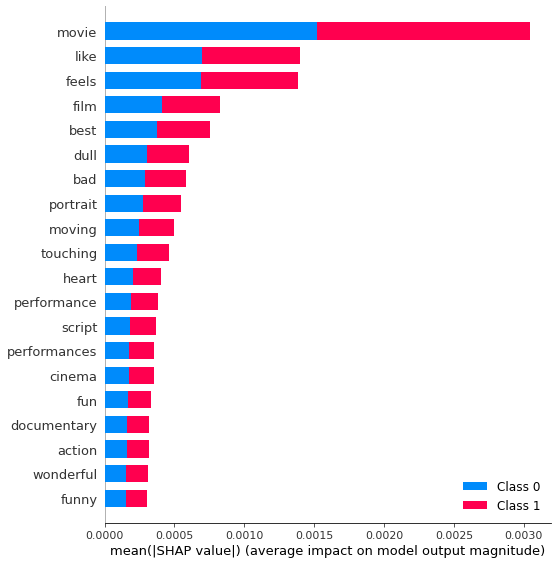

In [11]:
!pip install shap
import shap 
explainershap = shap.TreeExplainer(rf)
shap_values = shap.TreeExplainer(rf).shap_values(count_vect_df, check_additivity = False)
shap.summary_plot(shap_values, count_vect_df, plot_type="bar")